# Self Attention GANの実装


## Library

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

## self attentionとは
DCGANのGeneratorではDeconvで拡大する際どうしても局所情報の拡大になってしまい、大域的な情報が含まれない<br>
大域的な情報を含んだ拡大を実現するのがself attentionという技術

## 1x1 Convolutions (pointwise convolution)とは
出力チャネルが1だけ -> 入力xをチャネルごとに線形和をとったもの<br>
出力チャネルが複数 -> 異なる係数で（重み）でチャネルごとに線形和をとったものを出力チャネル分だけ用意する<br>

次元圧縮とも言える<br>
情報が欠落しにくい線形和の係数を学習してくれる

次元が圧縮され、計算量が少なくなることを活かして、エッジ端末で使われるmobile netでも使用される

## Spectral Normalizationとは
ネットワークの重みの正規化<br>
GANがうまく学習するにはDiscriminatorがリプシッツ連続星を保つ必要がある→<br>
リプシッツ連続をDiscriminatorのネットワークが有するにはどうすればいいか→<br>
Spectral Normalizationで重みを正規化する

## self attentionモジュールの実装

In [8]:
class Self_Attention(nn.Module):
    """
    self attentionのlayer
    """
    
    def __init__(self, in_dim):
        """
        query:
            元の入力xの転置に対応するもの
        key:
            元の入力xに対応するもの
        value:
            attention mapと掛け算する対象
        """
        super(Self_Attention, self).__init__()
        
        # pointwise convolutionを用意
        # pointwiseなのでkernel_size=1
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        # attention map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)
        
        # もとの入力ｘとself attention map(o)を加算するときの係数
        # 最初はgammma=0で学習させていく
        # nn.Parameter : pytocrhで学習可能な変数を作成する命令
        # これはインスタンス変数で保持しておく必要があるのかな？
        self.gamma = nn.Parameter(torch.zeros(1))  
        
    def forward(self, x):
        # 入力変数  B, C, W, H
        X = x
        
        # 畳み込み後にサイズを変更 B, C', W, H -> B, C', N
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # channelのサイズが変わるので-1
        proj_query = proj_query.permute(0, 2, 1)  # 転置　　B, N, C'
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # channelのサイズが変わるので-1
                                                                                   # B, C', N

        # 掛け算
        S = torch.bmm(proj_query, proj_key)  # bmm : バッチごとの掛け算
        
        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするsoftmax
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置
        
        # self attentino mapを計算
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # B, C, N
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))  # bmm : バッチごとの掛け算
        # attention mapは転置して掛け算
        
        # self attentino mapであるoのテンソルサイズをXに揃えて出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma*o
        
        return out, attention_map  # attention_mapはattentionの強さを可視化するために使用

## Generatorの実装
DCGANからの変更点
- Deconv層にSpectral Normalizationを追加する
- self attentionモジュールを追加する

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        # self attention層を追加
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        # self attention層を追加
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(
            # Spectral Normalizationはしない
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())  # -1~1の出力になる
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2  #  outと2つのattention_mapを返す
        
        

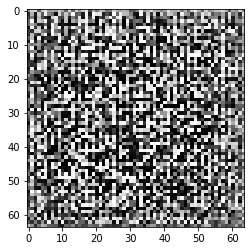

In [15]:
# 動作確認
# どこかにミスがある前提で動作確認するほうがいい
# 修正するための動作確認だから
import matplotlib.pyplot as plt
%matplotlib inline

# 偽画像の生成
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, attention_map1, attention_map2 = G(input_z)

# 偽画像の表示
image_transformed = fake_images[0][0].detach().numpy()  # 64x64
plt.imshow(image_transformed, 'gray')
plt.show()
